In [1]:
import torch

CONTENT_FILES = './input/bdl'
STYLE_FILES = './input/clb'


windowSize = 72         # the input width of the model
vecLen = 128            #length of vector generated by siamese vector
shape = 24              #length of time axis of split specrograms to feed to generator            

batch_size = 32         #batch size
delta = 2.              #constant for siamese loss


# If gpu is available
if torch.cuda.is_available():  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')



# Reading

loaded 1132 files from ./input/bdl
loaded 1132 files from ./input/clb
sampleRate: 22050


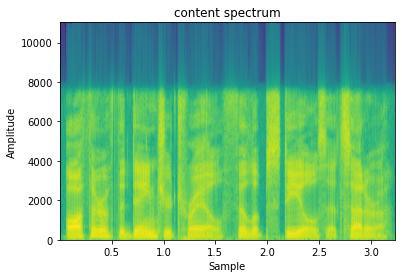

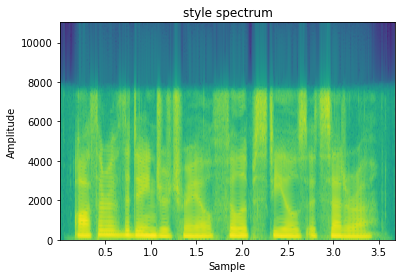

In [2]:

from glob import glob
from utils import *
import torch

def loadData(path):
    files = glob(f'{path}/*.wav')
    data = []
    for file in files:
        x= loadFile(file)
        data.append(x)
    print(f'loaded {len(files)} files from {path}')
    return data


def transformData(Xs):
    ret = []
    for x in Xs:
        ret.append(wav2spectrum(x))
    return ret
    

x_content = loadData(CONTENT_FILES)
x_style = loadData(STYLE_FILES)


a_content = transformData(x_content)
a_style = transformData(x_style)


print(f'sampleRate: {sampleRate}')

plot_spectrogram_with_raw_signal(x_content[0], sampleRate, 'content spectrum')
plot_spectrogram_with_raw_signal(x_style[0], sampleRate, 'style spectrum')

H_Spec = a_content[0].shape[0]


# Making Dataset

In [3]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class myDataset(Dataset):
    def __init__(self, content, style, sampleNumber = 50):
        self.style = []
        self.content = []
        for c, s in zip(content, style):
            H_S, W_S = s.shape
            H_C, W_C = c.shape 
            indices_C = np.random.randint(W_C - windowSize, size = sampleNumber)
            indices_S = np.random.randint(W_S - windowSize, size = sampleNumber)
        
            for i in indices_C:
                tensor = torch.tensor(c[None, :, i: i + windowSize])
                self.content.append(tensor)

            for i in indices_S:
                tensor = torch.tensor(s[None, :, i: i + windowSize])
                self.style.append(tensor)

    def __getitem__(self, index):
        return self.content[index], self.style[index]

    def __len__(self):
        return len(self.content)

dataset = myDataset(a_content, a_style)

train_loader = DataLoader(
    dataset, batch_size = batch_size
)

print(f'Load {len(dataset)} samples')


Load 56600 samples


# Losses

In [15]:
import torch.nn.functional as F

def mae(x, y):
    return torch.mean(torch.abs(x - y))

def mse(x, y):
    return torch.mean((x - y)**2)

def loss_travel(siam_x_1, siam_x_1_gen, siam_x_2, siam_x_2_gen):
    L1 = torch.mean(((siam_x_1 - siam_x_2) - (siam_x_1_gen - siam_x_2_gen))**2)
    L2 = torch.mean(torch.sum(-(F.normalize(siam_x_1 - siam_x_2, p = 2, dim = -1) * F.normalize(siam_x_1_gen - siam_x_2_gen, p = 2, dim = -1)), dim = -1))
    return L1 + L2

def loss_siamses(siam_x_1, siam_x_2, zero, delta):
    logits = torch.sqrt(torch.sum((siam_x_1 - siam_x_2)**2 ,dim = -1, keepdims = True))
    return torch.mean(torch.square(torch.maximum(delta - logits, zero)))

def d_loss_f(fake, zero):
    return torch.mean(torch.maximum(1 + fake, zero))

def d_loss_r(real, zero):
    return torch.mean(torch.maximum(1 - real, zero))

def g_loss_f(fake):
    return torch.mean(-fake)
    


# Setting

In [8]:

learning_rate_SG = 0.00001
learning_rate_D = 0.000005

"""
L_D = L_{D, adv}
L_G = L_{G, adv} + alpha L_{G, id} + beta L_{(G, S), TraVeL}
L_S = beta L_{(G, S), TraVeL} + gamma L_{S, margin}
"""

alpha = 10.0 
beta = 0.5
gamma = 10.0

max_epochs = 20       # maximum epochs

load_model_path = './saved_model/bdl2clb/epoch_18'  # path of the pretrained model
saved_experiment_path = './saved_model/bdl2clb'   # path of the saved model

if not os.path.exists(saved_experiment_path):
    os.mkdir(saved_experiment_path)

    
plot_spec = False    # plot spectrum when training 
saved_epoch = 3      # save model period

pretrained = False   # If loading the pretrained model 



# Training

In [ ]:

from models import Siamese, Generater, Discriminator
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import pickle as pkl
import torch 
import os

# Crop function for training
def crop(x):
    WW = windowSize // 3
    return x[:, :, :, : WW], x[:, :, :, WW: WW * 2], x[:, :, :, WW * 2:]


model_S = Siamese(input_size = (1, H_Spec, windowSize // 3), output_size = vecLen)
model_G = Generater(input_size = (1, H_Spec, windowSize // 3))
model_D = Discriminator(input_size = (1, H_Spec, windowSize))


# load pretrained model
if pretrained :
    model_S.load_state_dict(torch.load(os.path.join(load_model_path, 'model_S.pt')))
    model_G.load_state_dict(torch.load(os.path.join(load_model_path, 'model_G.pt')))
    model_D.load_state_dict(torch.load(os.path.join(load_model_path, 'model_D.pt')))


optimizer_SG = optim.Adam(
    list(model_S.parameters()) + list(model_G.parameters()),
    lr = learning_rate_SG
)

optimizer_D = optim.Adam(
    model_D.parameters(),
    lr = learning_rate_D
)


model_S.to(device)
model_G.to(device)
model_D.to(device)


model_S.train()
model_G.train()
model_D.train()

gupt = 3

losses = {
    'loss_id': [],
    'loss_m': [],
    'loss_dr': [],
    'loss_df': [],
    'loss_g': [],
    'loss_D': [],
    'loss_GS': []
}

for epoch in range(1, max_epochs + 1):
    
    
    loss_g_epoch = 0.0
    loss_m_epoch = 0.0
    loss_id_epoch = 0.0
    loss_dr_epoch = 0.0
    loss_df_epoch = 0.0

    loss_D_epoch = 0.0
    loss_GS_epoch = 0.0

    with tqdm(train_loader, unit = 'batch') as tepoch:
        for i, (x, y) in enumerate(tepoch):
            
            tepoch.set_description(f'Training Epoch {epoch:03d}/{max_epochs:03d}')

            x = x.to(device)
            y = y.to(device)

            x1, x2, x3 = crop(x)
            y1, y2, y3 = crop(y)

            if i % gupt == 0: # Train all

                optimizer_SG.zero_grad()
                optimizer_D.zero_grad()

                gen_x_1 = model_G(x1)
                gen_x_2 = model_G(x2)
                gen_x_3 = model_G(x3)
                
                gen_y_1 = model_G(y1)
                gen_y_2 = model_G(y2)
                gen_y_3 = model_G(y3)

                gen = torch.cat([gen_x_1, gen_x_2, gen_x_3], dim = -1)

                iden_gen = model_D(gen)
                iden_ori = model_D(y)

                siam_x_1_gen = model_S(gen_x_1)
                siam_x_2_gen = model_S(gen_x_3)

                siam_x_1 = model_S(x1)
                siam_x_2 = model_S(x3)


                # zero tensor
                zero = torch.zeros(vecLen, device = device)

                # identity mapping loss
                loss_id = (mae(y1, gen_y_1) + mae(y2, gen_y_2) + mae(y3, gen_y_3)) / 3.0

                # travel loss
                loss_m = loss_travel(siam_x_1, siam_x_1_gen, siam_x_2, siam_x_2_gen) + loss_siamses(siam_x_1, siam_x_2, zero, 2.0)

                # generator and critic losses
                loss_g = g_loss_f(iden_gen)
                loss_dr = d_loss_r(iden_ori, zero)
                loss_df = d_loss_f(iden_gen, zero)
                

                loss_D = (loss_dr + loss_df) / 2

                loss_GS = loss_g + alpha * loss_m + beta * loss_id


                loss_g_epoch += loss_g.item()
                loss_m_epoch += loss_m.item()
                loss_id_epoch += loss_id.item()
                loss_dr_epoch += loss_dr.item()
                loss_df_epoch += loss_df.item()
                
                loss_D_epoch += loss_D.item()
                loss_GS_epoch += loss_GS.item()


                loss_D.backward(retain_graph = True)
                loss_GS.backward()

                optimizer_D.step()
                optimizer_SG.step()


            else: # Train Critic only
                
                optimizer_D.zero_grad()

                gen_x_1 = model_G(x1)
                gen_x_2 = model_G(x2)
                gen_x_3 = model_G(x3)

                gen = torch.cat([gen_x_1, gen_x_2, gen_x_3], dim = -1)

                iden_gen = model_D(gen)
                iden_ori = model_D(y)

                # zero tensor
                zero = torch.zeros(vecLen, device = device)

                loss_dr = d_loss_r(iden_ori, zero)
                loss_df = d_loss_f(iden_gen, zero)

                loss = (loss_dr + loss_df) / 2.0

                
                loss_dr_epoch += loss_dr.item()
                loss_df_epoch += loss_df.item()

                loss_D += loss.item()


                loss.backward()

                optimizer_D.step()
            
            
    if epoch % saved_epoch == 0 :

        epoch_path = os.path.join(saved_experiment_path, f'epoch_{epoch}')

        if not os.path.exists(epoch_path):
            os.mkdir(epoch_path)
 
        index = np.random.randint(len(a_content))

        if plot_spec:
            plot_spectrogram_with_raw_signal(x_content[index], sampleRate, 'input spectrum')

        a_input = a_content[index]
        H, W = a_input.shape

        W_output = W - (W % shape) 
        a_output = np.zeros((H, W_output))

        tensor_input = torch.tensor(a_input[:, :W_output])
        tensor_input = tensor_input.to(device)

        model_G.eval()

        for i in range(0, W_output, shape):
            a_output[:, i: i + shape] = model_G(tensor_input[:, i:i + shape].view(1, 1, H, shape)).detach().cpu().numpy()

        x_output = spectrum2wav(a_output)
        
        if plot_spec:
            plot_spectrogram_with_raw_signal(x_output, sampleRate, 'output spectrum')


        # saved generated waveform
        x_output = scale_audio(x_output, 20)
        writeFile(os.path.join(epoch_path, 'gen.wav'), x_output)

        # save models
        torch.save(model_S.state_dict(), os.path.join(epoch_path, 'model_S.pt'))
        torch.save(model_G.state_dict(), os.path.join(epoch_path, 'model_G.pt'))
        torch.save(model_D.state_dict(), os.path.join(epoch_path, 'model_D.pt'))

        print(f'Save model and generate waveform at epoch {epoch}, total loss: {loss_GS_epoch + loss_D_epoch}')
        
        model_G.train()



    losses['loss_g'].append(loss_g_epoch)
    losses['loss_m'].append(loss_m_epoch)
    losses['loss_id'].append(loss_id_epoch)
    losses['loss_dr'].append(loss_dr_epoch)
    losses['loss_df'].append(loss_df_epoch)

    losses['loss_D'].append(loss_D_epoch)
    losses['loss_GS'].append(loss_GS_epoch)
    

info = {
    'alpha': alpha,
    'beta': beta,
    'delta': delta,
    'gamma': gamma,
    'loss': losses,
    'epochs': max_epochs,
    'learning_rate_D': learning_rate_D,
    'learning_rate_SG': learning_rate_SG,
    'input_shape': (1, H_Spec, windowSize),
    'vecLen': vecLen,
    'batch_size': batch_size,
    'saved_model_path': saved_experiment_path,
    'load_model_path': load_model_path,
    'pretrained': pretrained
}

with open(os.path.join(saved_experiment_path, 'train_info.pkl'), 'wb') as f:
    pkl.dump(info, f)

 

# Show training process

[649.4383781217039, 3481.410946726799, 3586.48024225235, 3176.5201003551483, 3169.110087633133, 3282.334837794304, 3450.7343802452087, 3502.9758853912354, 3535.36839056015, 3496.564386844635, 3469.314532995224, 3480.155131459236, 3491.4518353939056, 3469.5304259061813, 3478.441449403763, 3518.9883937835693, 3524.894750595093, 3524.131765961647, 3520.6424709558487, 3519.345446705818]


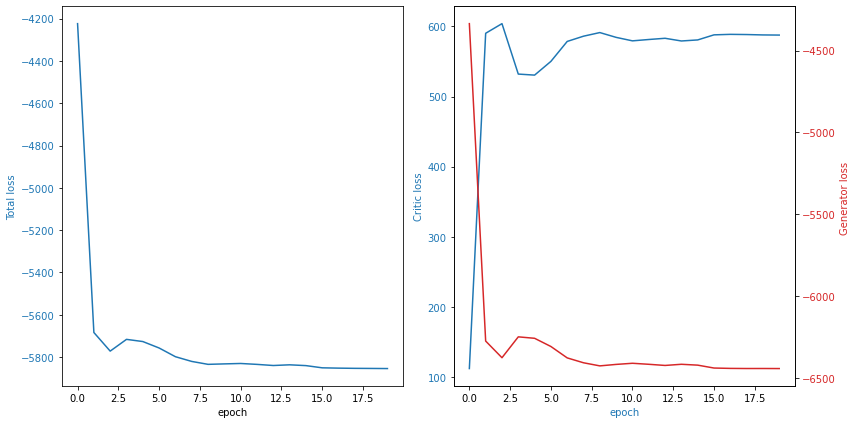

In [57]:

# print(losses['loss_g'])

print(losses['loss_df'])

total_loss = np.array(losses['loss_D']) + np.array(losses['loss_GS'])

plot_curve(losses['loss_D'], losses['loss_GS'], total_loss, 'Critic loss', 'Generator loss ', 'Total loss', False)
# plot_curve(losses['loss_g'])
# print(losses['loss_m'])
# print(losses['loss_g'])
# print(losses['loss_GS'])




# Save model

In [22]:
torch.save(model_S.state_dict(), os.path.join(saved_experiment_path, 'model_S.pt'))
torch.save(model_G.state_dict(), os.path.join(saved_experiment_path, 'model_G.pt'))
torch.save(model_D.state_dict(), os.path.join(saved_experiment_path, 'model_D.pt'))

# Load Model

In [9]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from models import *
from utils import hop
import torch 

model_S = Siamese(input_size = (1, hop, windowSize // 3), output_size = vecLen)
model_G = Generater(input_size = (1, hop, windowSize // 3))
model_D = Discriminator(input_size = (1, hop, windowSize))


model_S.load_state_dict(torch.load(os.path.join(load_model_path, 'model_S.pt')))
model_G.load_state_dict(torch.load(os.path.join(load_model_path, 'model_G.pt')))
model_D.load_state_dict(torch.load(os.path.join(load_model_path, 'model_D.pt')))


<All keys matched successfully>

# Generate output



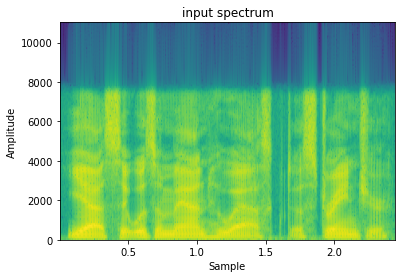

192 281


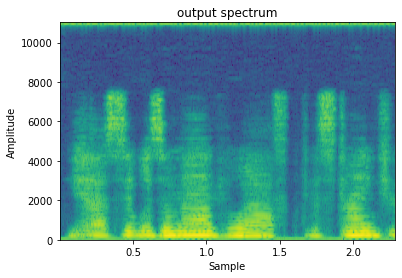

In [15]:

# from preprocess import *
from utils import *

INPUT_FILE = './input/bdl/arctic_a0063.wav'

N_FFT = 512


x_input = loadFile(INPUT_FILE)
a_input = wav2spectrum(x_input)

plot_spectrogram_with_raw_signal(x_input, sampleRate, 'input spectrum')


H, W = a_input.shape
print(H, W)

w = windowSize // 3

W_output = W - (W % w) 
a_output = np.zeros((H, W_output))


# tensor_input = torch.transpose(torch.transpose(torch.tensor(a_input[:, :W_output]) ,1, 0).reshape(-1, 1, windowSize, H), -2, -1)
tensor_input = torch.tensor(a_input[:, :W_output])


model_G.to(device)
tensor_input = tensor_input.to(device)

model_G.eval()

for i in range(0, W_output, w):
    a_output[:, i: i + w] = model_G(tensor_input[:, i:i + w].view(1, 1, H, w)).detach().cpu().numpy()

# a_output = model_G(tensor_input).reshape(H, W_output).detach().cpu().numpy()

# a_output = np.where(a_output == np.inf, 1e9, a_output)
# a_output = np.where(a_output == np.nan, 1e9, a_output)

x_output = spectrum2wav(a_output)

plot_spectrogram_with_raw_signal(x_output, sampleRate, 'output spectrum')



# Save file

In [14]:
import os

filename = 'TraVelGan.wav'

x_output = add_audio(x_output, 40)
writeFile(os.path.join('./output/', filename), x_output)
